In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from astropy.coordinates import SkyCoord
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import compute_Cells_from_map
import dipole
from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

### inputs

In [3]:
# inputs used across the entire notebook
NSIDE = 64

# kwargs for each sample to pass to SecrestDipole() to load
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                      blim=30, maglim=16.4, load_init=False)
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=False, compcorrect=True)

### load sample

In [4]:
# load the source density table for the final sample (masked and density-corrected)
d = SecrestDipole(**quaia_kwargs)
t = d.load_hpxelatcorr()

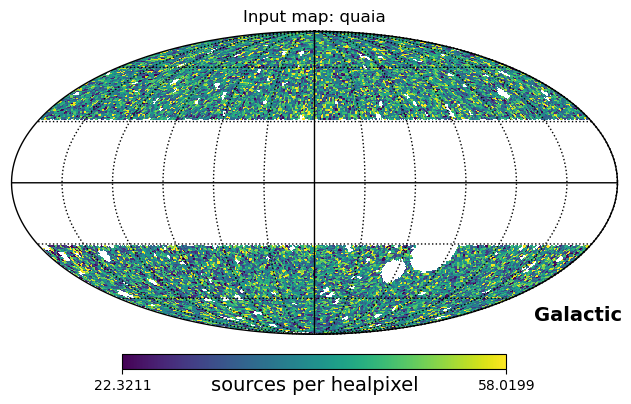

In [5]:
# construct map from source density table
map_to_fit = np.empty(hp.nside2npix(NSIDE))
map_to_fit[:] = np.nan
map_to_fit[t['hpidx']] = t['elatdenscorr']
mean, std = np.nanmean(map_to_fit), np.nanstd(map_to_fit)
fig = plt.figure(figsize=(8,4))
hp.mollview(map_to_fit, coord=['C','G'], title=f'Input map: {d.catname}', unit='sources per healpixel',
            badcolor='w', min=mean-2*std, max=mean+2*std, fig=fig)
hp.graticule()

### get longitude subsamples

In [6]:
# divide the full sample into equal longitude wedges: leave out one wedge in each subsample
nsamples = 12
lonavg, subsamples = get_longitude_subsamples(t, nsamples, NSIDE=NSIDE)

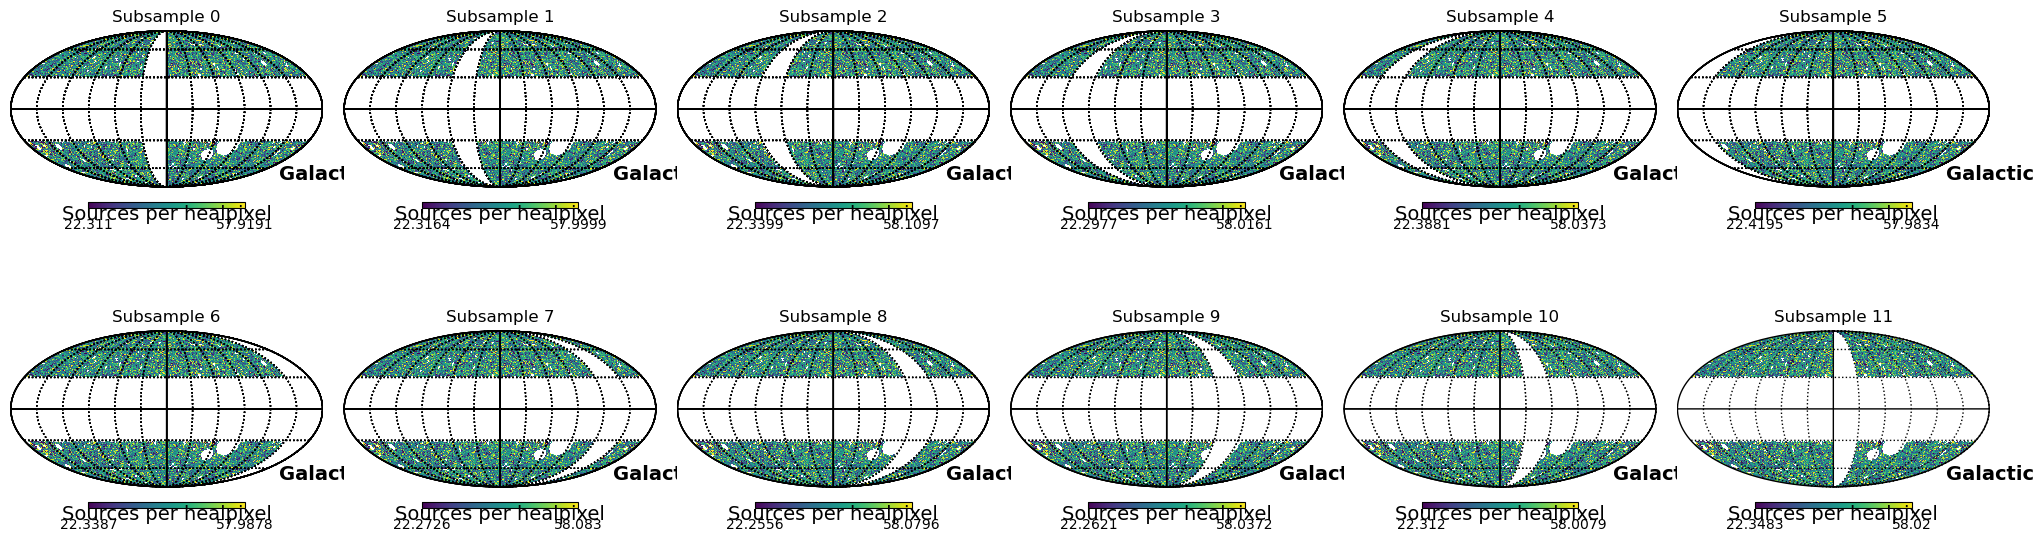

In [7]:
# plot the subsamples
fig = plt.figure(figsize=(20,6))
for i, subsample in enumerate(subsamples):
    mean, std = np.nanmean(subsample), np.nanstd(subsample)
    hp.mollview(subsample, coord=['C','G'], title=f'Subsample {i}', badcolor='w', unit='Sources per healpixel',
                min=mean-2*std, max=mean+2*std, sub=(nsamples//6, nsamples//2, i+1))
    hp.graticule()

### combine Cells into a single C for all ells

The usual definition is
$$
C_\ell = \frac{1}{2\ell+1}\sum_{m=-\ell}^\ell a_{\ell m}^2 = \langle a_{\ell m}^2\rangle_m
$$
where $\langle\rangle$ indicates a mean.
So we have a single $C$ for each $\ell$.

If we take the mean over $\ell$ too, then we can get a single $C$ for all $\ell$ up to some $\ell_\mathrm{max}$:

$$
C = \langle C_\ell\rangle_\ell = \langle\langle a_{\ell m}^2\rangle_m\rangle_\ell
$$

In [9]:
# define a wrapper function to meet the input requirements of the jackknife function:
#   we just want to return the values used in the jackknife
def compute_Cell_jk_sample(sample, max_ell):
    """
    Returns a single power Cell from an input `sample` healpix map and `max_ell` to fit.
    """
    
    # !! this function returns the Cells of pars scaled by the mean source density in the map:
    #  compute_Cells(pars / (0.5 * np.sqrt(1/np.pi) * pars[0]))
    
    ells, Cells = compute_Cells_from_map(sample, max_ell)
    Cell = np.mean(Cells)
    return Cell

In [13]:
# explore the dependence of the fit on the max ell

# choose a few max ells
max_ells = np.arange(1, 8)

ellss = []
combined_Cells = []
stds = []
for i, max_ell in enumerate(max_ells):
    print(max_ell)
    # Cells for the full sample
    ells, Cells = compute_Cells_from_map(map_to_fit, max_ell)
    Cell = np.mean(Cells)
    combined_Cells.append(Cell)

    # jackknife uncertainty from the LOO samples constructed above
    stds.append(compute_jackknife_uncertainty(subsamples, compute_Cell_jk_sample, max_ell=max_ell))

1
2
3
4
5
6
7


In [ ]:
for i, max_ell in enumerate(max_ells):
    print(f"max_ell = {max_ell}:\tCell = {combined_Cells[i]:.3f}\tstd = {stds[i]:.3f}")